In [1]:
from diffusers import AutoPipelineForText2Image, StableDiffusionPipeline, AutoencoderKL
import torch
from torchvision import transforms
from PIL import Image

torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device = "cuda" if torch.cuda.is_available() else "cpu"
device ='cpu'

url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"  # can also be a local file
model = AutoencoderKL.from_single_file(url).to(device)

model_path = "CompVis/stable-diffusion-v1-4"
model_path = "/data/maryam.sana/diffusers/examples/text_to_image/sd_mod"
pipe = StableDiffusionPipeline.from_pretrained(model_path, use_auth_token=True).to(device)

/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]


In [2]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
img_path = 'results/edited_image_dog.png'
image = Image.open(img_path)
print('size:', image.size) 
image_resized = image.resize((512,512))

size: (512, 512)


In [3]:
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
latents = model.encode(image_tensor)
latents = latents.latent_dist.sample()

In [4]:
img = model.decode(latents,return_dict=False)[0].detach()
img.shape

torch.Size([1, 3, 512, 512])

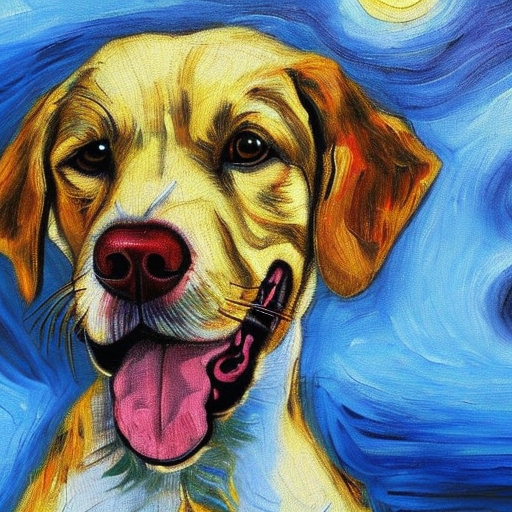

In [5]:
pipe.image_processor.postprocess(img,output_type='pil')[0]

# so decoder works fine , needs normalization 

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [02:46<00:00,  3.33s/it]


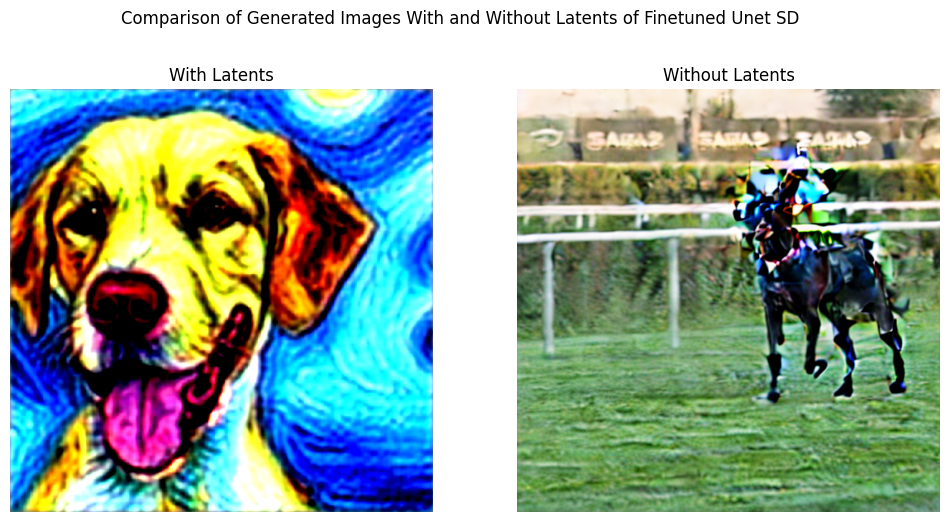

In [6]:
import matplotlib.pyplot as plt

pred_with_latents = pipe(prompt="dog with smile", height=512, width=512,latents=latents).images[0]
pred = pipe(prompt="dog with smile", height=512, width=512).images[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image generated with latents on the first subplot
ax1.imshow(pred_with_latents)
ax1.set_title("With Latents")
ax1.axis('off')  # Turn off axis

# Display the image generated without latents on the second subplot
ax2.imshow(pred)
ax2.set_title("Without Latents")
ax2.axis('off')  # Turn off axis

# Add an overall title
plt.suptitle("Comparison of Generated Images With and Without Latents of Finetuned Unet SD")

# Show the plot
plt.show()